In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
!pip install rank_bm25

/content


In [4]:
import os
import sys
import psutil
import nltk
import time
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core import display as ICD
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from rank_bm25 import BM25Okapi, BM25L, BM25Plus
nltk.download('punkt')
nltk.download('wordnet')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/hacknu"
def show_memory(st):
  process = psutil.Process(os.getpid())
  print(f'Memory usage {st}:', process.memory_info().rss / 1024 / 1024, 'mb')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
show_memory('at start')

Memory usage at start: 163.30859375 mb


In [8]:
%cd "/content/drive/MyDrive/Colab Notebooks/hacknu"

/content/drive/MyDrive/Colab Notebooks/hacknu


In [ ]:
!kaggle datasets download -d snapcrack/all-the-news

all-the-news.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
df = pd.read_feather('articles4.f')
# df = df.head(10)
# df1 = pd.read_csv('articles1.csv')
# df2 = pd.read_csv('articles2.csv')
# df3 = pd.read_csv('articles3.csv')
# frames = [df1, df2]
# df = pd.concat(frames)
# df.set_index('id', inplace=True)

In [43]:
df.apply(lambda row: row.content[200:], axis=1) #head()

0         twintheincomingtrumpadministrationcouldchoosetonolongerdefendtheexecutivebranchagainstthesuitwhichchallengetheadministrationsauthoritytospendbillionofdollaronhealthinsurancesubsidyforandamericanhandinghouserepublicanabigvictoryonissuebutasuddenlossofthedisputedsubsidycouldconceivablycausetheheal...
1         ecrimescenegonecoldabandofyellowpolicetapeblowinginthebreezethesouthbronxjustacrosstheharlemriverfrommanhattanandonceshorthandforurbandysfunctionstillsuffersviolenceatlevellongagoslashedinmanyotherpartofnewyorkcityandyetthecitysefforttofightitremainsplinteredunderfundedandburdenedbyscandalinthe4...
2         butwhattheydidnotknowwathatthefilmsstrikingappearancehadbeencreatedbyachineseimmigrantartistwhotookahisinspirationthelandscapepaintingofthesongdynastytheextentofhiscontributiontobambiwhichremainsamarkforfilmanimationwouldnotbewidelyknownfordecadelikethefilmstitlecharactertheartisttyruswongweathe...
3         aliandarnoldpalmerinsportandthehollywooddeathofcarriefishera

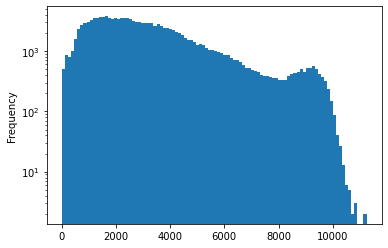

In [44]:
ax = df['content'].apply(len).plot.hist(bins=100, log=True)
# ax.set_xscale('log')

In [45]:
lemmatizer = WordNetLemmatizer()

def smart_tokenize(txt):
  tokens = nltk.word_tokenize(txt.lower())
  # return tokens
  return [lemmatizer.lemmatize(w) for w in tokens]

def tokenize_row(row):
  return smart_tokenize(row.content)

# df['content2'] = df.apply(lambda row: nltk.word_tokenize(row.content.lower()), axis=1)

In [13]:
# np.set_printoptions(threshold=sys.maxsize)
# df.reset_index().to_feather('model.f')
# df = pd.read_feather('model.f')
# df = pd.read_csv('model.csv')

In [14]:
import gc
gc.collect()

3144

In [15]:
bm25 = BM25L(df['content2'])

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
vectors = vectorizer.fit_transform(df.apply(lambda row: ' '.join(row.content2), axis=1))

In [18]:
def exact_match(subarr, arr):
  if len(subarr) >= 4 and ''.join(subarr) in ''.join(arr):
    return 1
  return 0

In [73]:
# queries = ['presidential election', 'olympic sport in rio', 'work desk', 'Katy Perry', 'Gennifer Flowers not attending first']
for query in [input('Enter search query:')]:
  print('query:', query)
  t1 = time.time()
  tokenized_query = smart_tokenize(query)
  doc_scores = bm25.get_scores(tokenized_query)
  result = df[['id','title', 'year']].copy()
  result['bm25score'] = pd.Series(doc_scores)
  tfid_query_vector = vectorizer.transform([query])
  result['cossim'] = (vectors * tfid_query_vector.T).todense()
  result['exact'] = df.content.apply(lambda x: int(''.join(tokenized_query) in x))
  result['content'] = df['content2'].apply(lambda x: ' '.join(x[:100]))
  # result.sort_values(by=['exact'], ascending=False, inplace=True)
  t2 = time.time() - t1
  result.sort_values(['exact', 'bm25score'], ascending=[False, False], inplace=True)
  ICD.display(result[['id','title', 'year', 'bm25score', 'cossim', 'exact', 'content']].head(5))
print('elapsed:', t2, 's')

Enter search query:ketty perry
query: ketty perry


,id,title,year,bm25score,cossim,exact,content
131859,204536,Rick Perry expresses ‘regret’ for pledging to abolish Energy Department,2017.0,374.155352,0.772934,0,former texas governor rick perry donald trump s nominee to run the energy department parried que...
42070,63397,Rick Perry launches comeback bid for White House,2015.0,285.013757,0.779146,0,washington cnn this time rick perry ha nowhere to go but up four year after his first presidenti...
68497,104205,"Back On The Trail To Help Ted Cruz, Rick Perry Says He Never Left",2016.0,274.255269,0.735125,0,iowa city iowa shortly before former texas governor rick perry dropped out of the presidential r...
127534,197256,"Big Little Lies season finale, “You Get What You Need”: a thrilling, terrifying end to the series",2017.0,269.761796,0.394644,0,this article discus the season finale of big little lie you get what you need and contains major...
142227,217637,Trump taps former Texas Gov. Rick Perry to head Energy Department he once vowed to abolish,2016.0,257.669462,0.509840,0,donald trump ha picked rick perry to head the energy department said two people familiar with th...


elapsed: 2.0217673778533936 s


In [70]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', None)

In [ ]:
show_memory('at the end')

Memory usage at the end: 6606.31640625 mb
